# Reproduce the plots in the paper

This notebook describes the steps necessary to analyze the experimental results and get the plots in the paper.
_As some cells require hours to run, the pre-computed results are in a dedicated folder: `src.utils.RESULTS_DIR`. These cells are commented out, but you can uncomment them for full reproducibility._

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns

from functools import reduce

import src.utils as u
import src.rank_metrics as rm
os.chdir("..")  # move kernel to EncoderBenchmarking

# Results loading

Load the merged results, stored in the `src.utils.RESULTS_DIR` directory (default: `experimental_results`).

In [2]:
df, rf = u.load_df_rf()

In [65]:
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

# Runtime

The plotted values are: for `no tuning` and `model tuning`. the time required to encode the dataset. For `full tuning`, the time required to tune the pipeline. For each inner fold and each combination of hyperparameters, encode the dataset, train and evaluate a model.

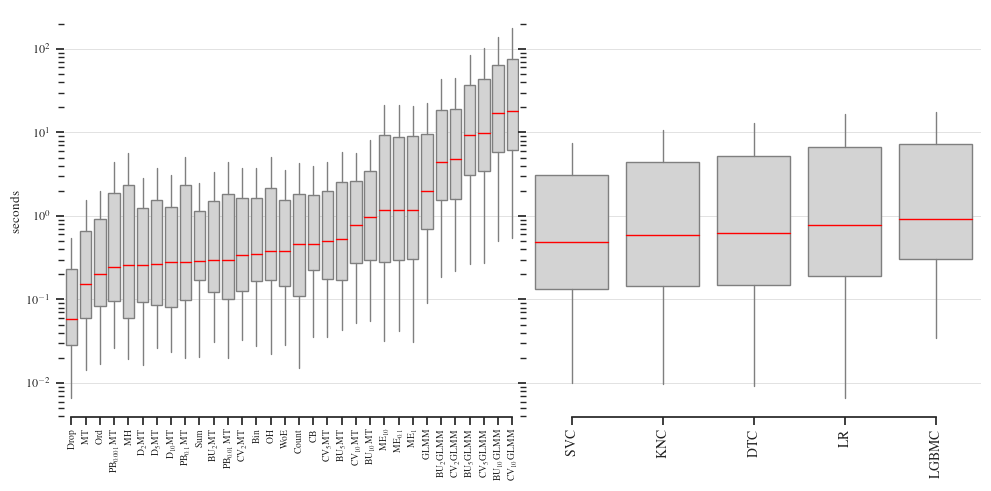

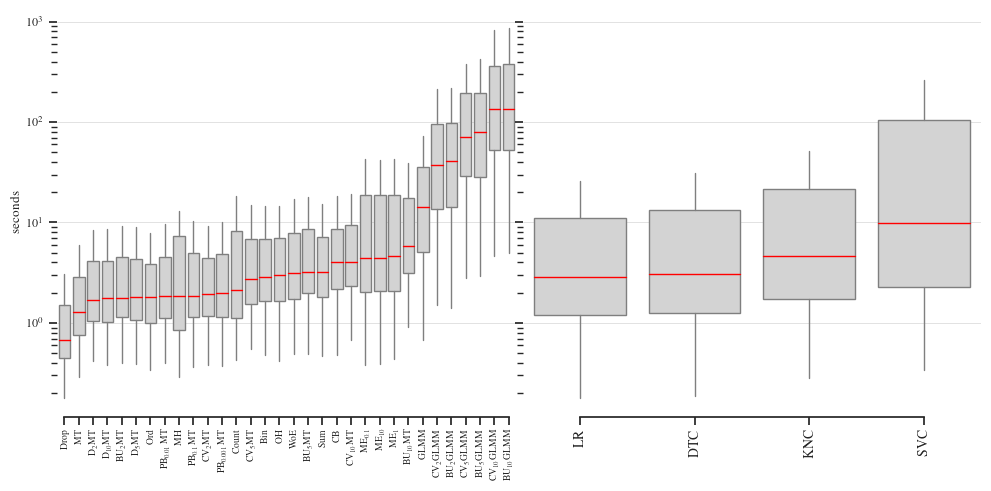

In [78]:
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

import pandas as pd

FACTORS = ["dataset", "model", "tuning", "scoring"]
HUE = ["encoder", "model"]

df = pd.read_csv("C:\\Data\\EncoderBenchmarking_results\\ExperimentalResults\\final.csv", index_col=0)
df = df.groupby(FACTORS+["encoder"])[["cv_score", "time"]].mean().reset_index()
df["encoder"] = df["encoder"].map(u.ENCODER_LATEX)

for it, tunings in enumerate([("no", "model"), ("full", )]):
    fig, axs = plt.subplots(1, len(HUE), sharey="all", figsize=(10, 5))
    for ia, (ax, factor) in enumerate(zip(axs, HUE)):
        ax.grid(axis="y", zorder=-1, linewidth=0.4)

        if factor == "encoder":
            color = "lightgrey"
            palette = None
            fontsize = 7
        else:
            color = "lightgrey"
            palette = u.COLORS
            fontsize = 10

        df_ = df.query("tuning in @tunings")

        u.sorted_boxplot_vertical(df_, y="time", x=factor, ax=ax, fliersize=0.1, color=color,
                                  showfliers=False,
                                  linewidth=1, showcaps=False,
                                  medianprops={"linestyle": "-",
                                               "color": "red"},
                                  )

        ax.set_yscale("log")
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            # horizontalalignment='right',
            fontweight='light',
            fontsize=fontsize
        )
        if ia == 0:
            ax.set_ylabel("seconds")
            ax.set_yticks([])
        else:
            ax.set_ylabel("")

        ax.set_xlabel("")

    sns.despine(left=True, trim=True)
    plt.tight_layout(w_pad=0.5)

    plt.savefig(f"C:\\Data\\EncoderBenchmarking_results\\Figures\\time_{'encoding' if it == 0 else 'fulltuning'}.pdf")
    # plt.show()

# Tuning Vs no tuning
In this section, we ask ourselves whether tuning was even beneficial.



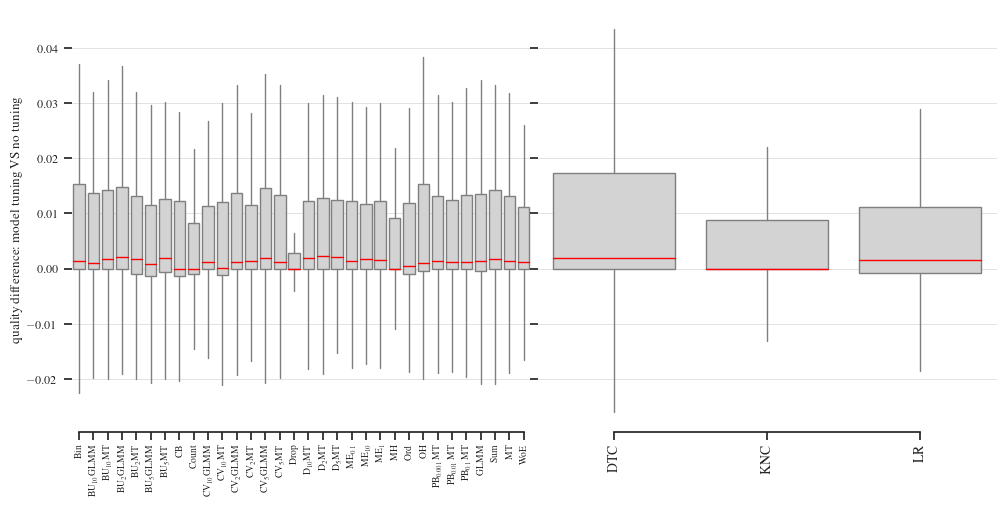

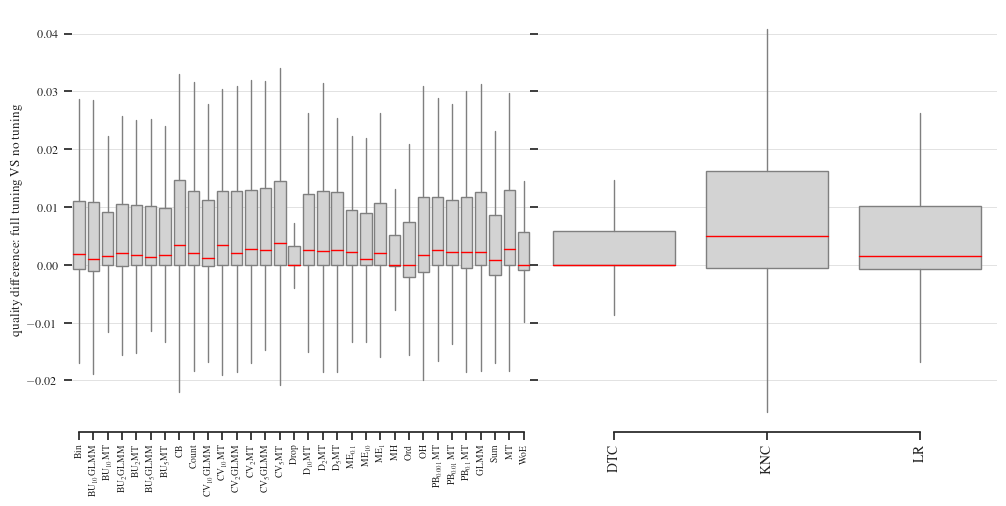

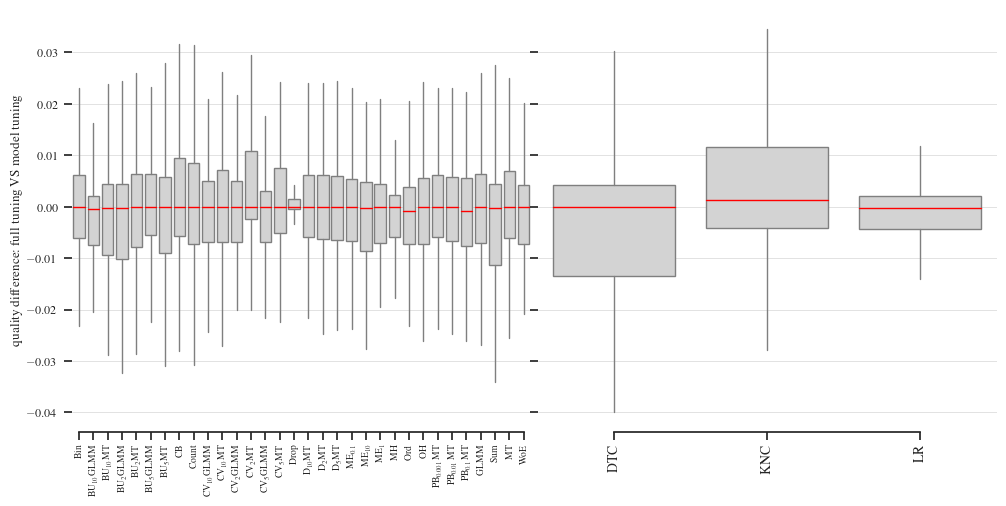

In [102]:
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

HUE = ["encoder", "model"]

pk = ["encoder", "dataset", "fold", "model", "tuning", "scoring"]
pk.remove("fold")
df = pd.read_csv("C:\\Data\\EncoderBenchmarking_results\\ExperimentalResults\\final.csv", index_col=0)
df = df.groupby(pk).cv_score.mean().reset_index()
df["encoder"] = df["encoder"].map(u.ENCODER_LATEX)

# limit to common datasets and models
df = df.query("dataset in @u.DATASETS_SMALL.values()").query("model in ['DTC', 'LR', 'KNC']")

df_full = df.query("tuning == 'full'")
df_model = df.query("tuning == 'model'")
df_no = df.query("tuning == 'no'")

pk.remove("tuning")

df_full_no = pd.merge(df_full, df_no, on=pk, how="inner")[pk + ["cv_score_x", "cv_score_y"]]
df_full_no["full_VS_no"] = df_full_no.cv_score_x - df_full_no.cv_score_y

df_full_model = pd.merge(df_full, df_model, on=pk, how="inner")[pk + ["cv_score_x", "cv_score_y"]]
df_full_model["full_VS_model"] = df_full_model.cv_score_x - df_full_model.cv_score_y

df_model_no = pd.merge(df_model, df_no, on=pk, how="inner")[pk + ["cv_score_x", "cv_score_y"]]
df_model_no["model_VS_no"] = df_model_no.cv_score_x - df_model_no.cv_score_y

comparisons = ["model_no", "full_no", "full_model"]
for comp in comparisons:
    if comp == "model_no":
        df_ = df_model_no.rename(columns={"model_VS_no": "gain"})
    elif comp == "full_no":
        df_ = df_full_no.rename(columns={"full_VS_no": "gain"})
    elif comp == "full_model":
        df_ = df_full_model.rename(columns={"full_VS_model": "gain"})
    else:
        raise ValueError()

    fig, axs = plt.subplots(1, len(HUE), sharey="all", figsize=(10, 5))
    for ia, (ax, factor) in enumerate(zip(axs, HUE)):
        ax.grid(axis="y", zorder=-1, linewidth=0.4)

        sns.boxplot(df_, y="gain", x=factor, ax=ax, color="lightgrey",
                                  showfliers=False,
                                  linewidth=1, showcaps=False,
                                  medianprops={"linestyle": "-",
                                               "color": "red"},
                                  )

        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            # horizontalalignment='right',
            fontweight='light',
            fontsize=7 if factor == "encoder" else 10
        )
        if ia == 0:
            t1, t2 = comp.split("_")
            ax.set_ylabel(f"quality difference: {t1} tuning VS {t2} tuning")
        else:
            ax.set_ylabel("")

        ax.set_xlabel("")

    sns.despine(left=True, trim=True)
    plt.tight_layout(pad=0.5)
    plt.savefig(f"C:\\Data\\EncoderBenchmarking_results\\Figures\\boxplot_tuningeffect_{comp}.pdf")